In [97]:
#Libraries required
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['weatherAUS.csv']


**Download the data**  
The data has been downloaded from kaggle datasets : https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

**Load the data**  
Load the data into the notebook (file : weatherAUS.csv)

In [98]:
data = pd.read_csv('../input/weatherAUS.csv')

In [99]:
# Let's see how our data looks like
print('Weather dataframe dimension: ',data.shape)
data.describe()

Weather dataframe dimension:  (142193, 24)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


Sunshine          74377
Evaporation       81350
Cloud3pm          85099
Cloud9am          88536
Pressure9am      128179
Pressure3pm      128212
WindDir9am       132180
WindGustDir      132863
WindGustSpeed    132923
WindDir3pm       138415
Humidity3pm      138583
Temp3pm          139467
WindSpeed3pm     139563
Humidity9am      140419
RainToday        140787
Rainfall         140787
WindSpeed9am     140845
Temp9am          141289
MinTemp          141556
MaxTemp          141871
Date             142193
Location         142193
RISK_MM          142193
RainTomorrow     142193
dtype: int64


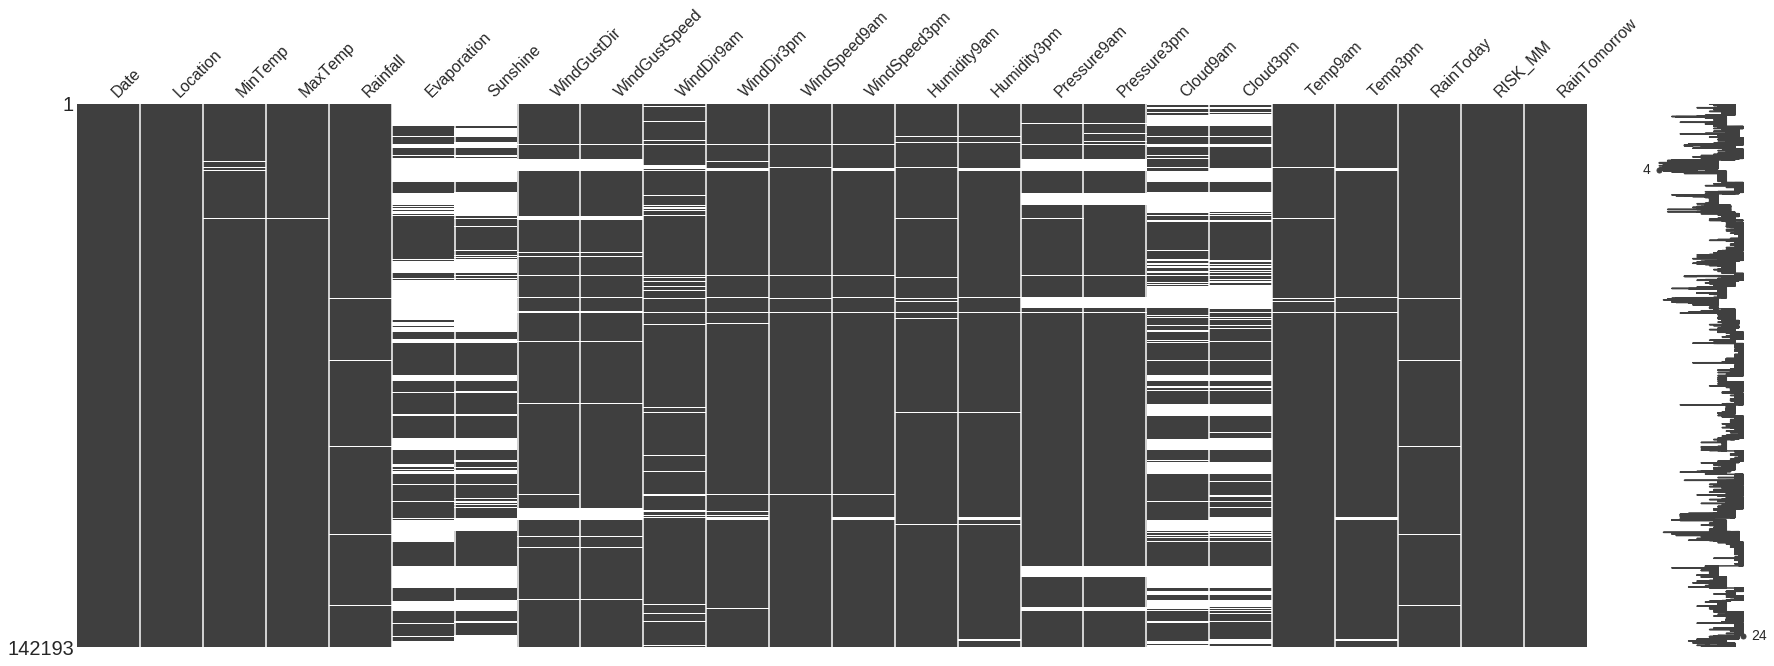

In [100]:
# We can see that there are lot of NaN values in the dataframe.  
# Let's check which column has maximum Nan values
print(data.count().sort_values())

#Graph to find missing values in the dataframe
import missingno
missingno.matrix(data, figsize = (30,10))

**Feature Selection**
1. From the above result we can see that the columns **Sunshine,Evaporation,Cloud3pm,Cloud9am** have more Nan or null values, they have less than 60% data, hence we are not including these columns.  
2. Also, we donot need **Location** column because we are trying to predict whether it will rain or not tommorrow and this analysis is not based on location.  
3. **Date** column can also be removed since the feature is not required for our prediction model.
4. We must remove **RISK_MM** feature since here we are trying to predict 'RainTommorrow'. RISK_MM is amount of rainfall in millimeters for the next day. It includes all forms of precipitation that reach the ground, such as rain, drizzle, hail and snow. Since it contains information about the future, and information directly about the target variable, including it would leak the future information to the model. Instead the variable itself can be actually used to determine whether or not it rained to create the binary target. For example, if RISKMM was greater than 0, then the RainTomorrow target variable is equal to Yes. Hence, using it as a predictor to build a model and then testing on this dataset would give the false appearance of a high accuracy.

In [101]:
data = data.drop(columns = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date','RISK_MM'],axis=1)

In [102]:
print(data.shape)
data.head()

(142193, 17)


,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


We can also write a function to track the missing values in each of the columns as below:

In [103]:
def find_missing_values(df,columns):
    missing_vals = {}
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
    return missing_vals

missing_values = find_missing_values(data,data.columns)
missing_values

{'MinTemp': 637,
 'MaxTemp': 322,
 'Rainfall': 1406,
 'WindGustDir': 9330,
 'WindGustSpeed': 9270,
 'WindDir9am': 10013,
 'WindDir3pm': 3778,
 'WindSpeed9am': 1348,
 'WindSpeed3pm': 2630,
 'Humidity9am': 1774,
 'Humidity3pm': 3610,
 'Pressure9am': 14014,
 'Pressure3pm': 13981,
 'Temp9am': 904,
 'Temp3pm': 2726,
 'RainToday': 1406,
 'RainTomorrow': 0}

Now let's see how to deal with missing values or Nan values

In [104]:
data = data.dropna(axis = 'index',how='any')
print(data.shape)

missing_values = find_missing_values(data,data.columns)
missing_values

(112925, 17)


{'MinTemp': 0,
 'MaxTemp': 0,
 'Rainfall': 0,
 'WindGustDir': 0,
 'WindGustSpeed': 0,
 'WindDir9am': 0,
 'WindDir3pm': 0,
 'WindSpeed9am': 0,
 'WindSpeed3pm': 0,
 'Humidity9am': 0,
 'Humidity3pm': 0,
 'Pressure9am': 0,
 'Pressure3pm': 0,
 'Temp9am': 0,
 'Temp3pm': 0,
 'RainToday': 0,
 'RainTomorrow': 0}

In [105]:
final = pd.DataFrame()

DATA TRANSFORMATION

In [106]:
#Data transformation
#For the categorical columns, we will change the value 'Yes' and 'No' to '1' and '0' respectively
data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)

#See unique values and convert them to int using pd.getDummies()
categorical_columns = ['WindGustDir', 'WindDir3pm', 'WindDir9am']
for col in categorical_columns:
    print(np.unique(data[col]))
# transform the categorical columns
final = pd.get_dummies(data, columns=categorical_columns)


['E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW' 'SW' 'W'
 'WNW' 'WSW']
['E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW' 'SW' 'W'
 'WNW' 'WSW']
['E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW' 'SW' 'W'
 'WNW' 'WSW']


In [107]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now lets standardise the data

In [108]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(final)
final = pd.DataFrame(scaler.transform(final), index=final.index, columns=final.columns)
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**FEATURE EXPLORATION**

**Feature 1 : 'RainTommorrow' (Target variable)**  

Description : Did it rain the next day?  
Values : 'Yes' , 'No'  
This is the dependent variable we want our machine learning model to predict, based on other independent variables  

0.0    87906
1.0    25019
Name: RainTomorrow, dtype: int64


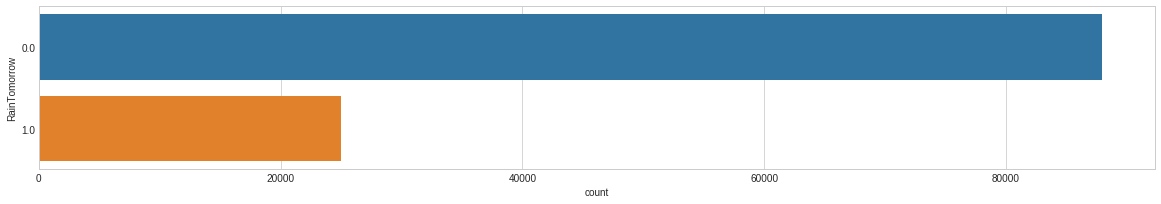

In [109]:
#Now we will just see how many times it rained the next day?
fig = plt.figure(figsize = (20,3))
sns.countplot(y='RainTomorrow', data=final);
print(final.RainTomorrow.value_counts())

From the graph we can know the ratio of cases where the next day is predicted as rainy day or not. From here, it gives a clue that - in future if our machine learning model is predicting more RainTomorrow = 'No' than number of RainTomorrow = 'Yes' with our test data, it means that we should check on the model. It basically gives us information about the bias or balance of targets in our data.
The table above the graph presents frequency counts for the binary variable.

**Feature 2: MinTemp**

Description : Minimum temperature in degree celsius

In [110]:
missing_values['MinTemp']

0

In [111]:
data.MinTemp.value_counts()

 12.7    709
 9.6     708
 8.9     702
 10.8    698
 10.7    695
 9.7     680
 11.9    676
 13.0    676
 10.2    674
 10.9    673
 10.5    670
 11.4    668
 11.3    666
 11.7    666
 12.0    664
 12.5    662
 12.4    661
 10.4    661
 11.0    661
 10.0    660
 11.8    658
 8.5     658
 9.0     657
 13.1    656
 13.2    652
 10.3    651
 8.3     651
 12.1    650
 11.5    650
 9.9     649
        ... 
-5.4       3
 29.2      3
-5.3       3
-4.1       2
-5.6       2
-6.7       2
 30.7      2
-6.1       2
-5.7       2
-5.8       2
-4.9       2
 29.6      2
-6.0       2
-7.0       1
 30.5      1
 31.9      1
 29.9      1
 31.0      1
 29.8      1
 30.2      1
 33.9      1
 31.2      1
 29.5      1
-8.2       1
 30.3      1
-5.9       1
-6.3       1
-7.6       1
-6.9       1
 31.8      1
Name: MinTemp, Length: 377, dtype: int64

since it is a continuous value, let's do binning and put this to a sepearate dataframe final_bin for visualization purpose

In [112]:
final_bin = pd.DataFrame()
final_bin['RainTomorrow'] = final['RainTomorrow']

In [113]:
final_bin['MinTemp'] = pd.cut(data['MinTemp'],bins = 5) #discretising the float numbers into categorical

In [114]:
final_bin.MinTemp.value_counts()

(8.64, 17.06]     51838
(0.22, 8.64]      30089
(17.06, 25.48]    27570
(-8.242, 0.22]     1804
(25.48, 33.9]      1624
Name: MinTemp, dtype: int64

In [115]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now lets see a function to create count and distribution for any variable we want

In [116]:
def plot_count_dist(df,label_column,target_column,figsize=(20,5)):
        fig = plt.figure(figsize=figsize)
        plt.subplot(1,2,1)
        sns.countplot(y=target_column, data = df);
        plt.subplot(1,2,2)
        sns.distplot(data.loc[data[label_column] == 1][target_column],
                    kde_kws={"label" : "Yes"});
        sns.distplot(data.loc[data[label_column] == 0][target_column],
                    kde_kws={"label" : "No"});
    

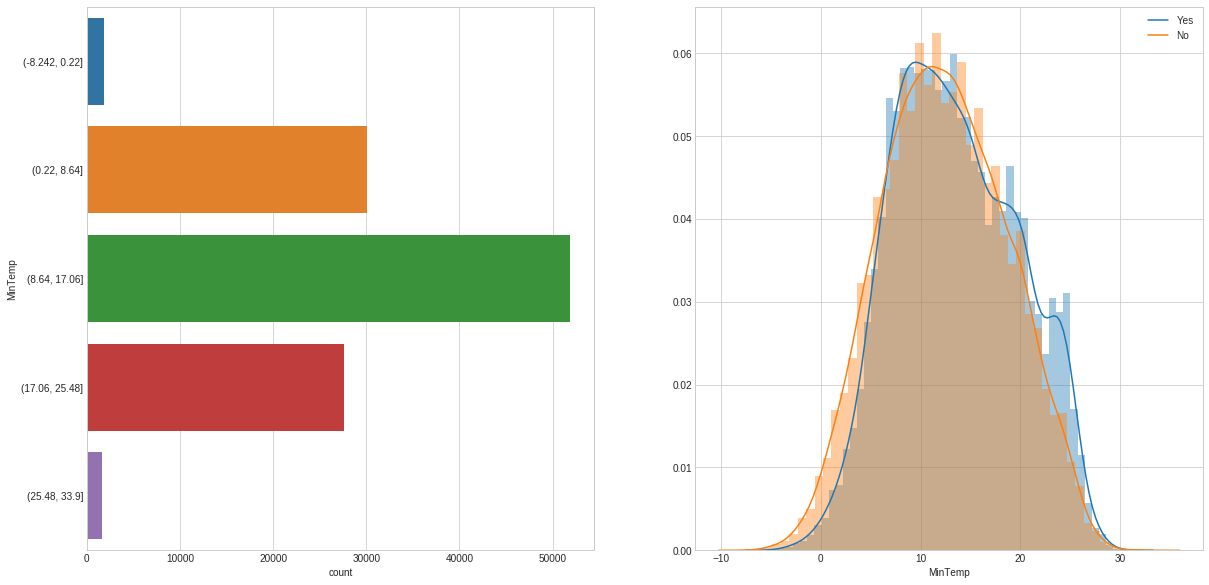

In [117]:
#Calling the function above we will visualise the MinTemp bin counts as well as the MinTemp distribution versus RainTomorrow
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'MinTemp', figsize = (20,10))

The left plot shows how many different values does MinTemp has. The right plot means that when MinTemp is between 0.0 - 0.3, the target RainTomorrow being 'No' is more and when MinTemp is greater than 0.6 the target RainTomorrow being 'Yes' is more. 

**Feature 3 : MaxTemp**

Description : The maximum temperature in degrees celsius

In [118]:
# Let's cross check the missing values
missing_values['MaxTemp']

0

In [119]:
data['MaxTemp'].value_counts()

19.9    634
20.4    632
25.0    618
19.8    616
19.6    615
20.7    612
20.3    611
20.1    611
21.1    608
20.8    606
23.4    606
19.5    605
19.4    601
19.0    601
18.9    598
18.5    597
20.2    595
19.7    594
20.9    591
19.3    591
22.4    590
21.0    590
21.4    590
24.9    590
20.0    586
22.2    584
21.3    584
21.2    583
23.6    582
22.6    579
       ... 
44.6      3
46.8      3
7.5       3
44.8      3
45.5      2
45.8      2
46.7      2
45.7      2
6.9       2
6.7       2
45.0      2
6.8       2
47.3      2
46.0      2
6.2       2
6.3       1
4.9       1
46.3      1
46.2      1
48.1      1
4.6       1
6.6       1
4.1       1
45.6      1
5.6       1
47.0      1
2.6       1
46.6      1
5.2       1
5.5       1
Name: MaxTemp, Length: 413, dtype: int64

since it is a continuous value, let's do binning and put this to our final_bin dataframe.

In [120]:
final_bin['MaxTemp'] = pd.cut(data['MaxTemp'],bins = 5) #discretising the float numbers into categorical

In [121]:
final_bin['MaxTemp'].value_counts()

(20.8, 29.9]     46443
(11.7, 20.8]     41135
(29.9, 39.0]     21038
(2.554, 11.7]     2332
(39.0, 48.1]      1977
Name: MaxTemp, dtype: int64

In [122]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


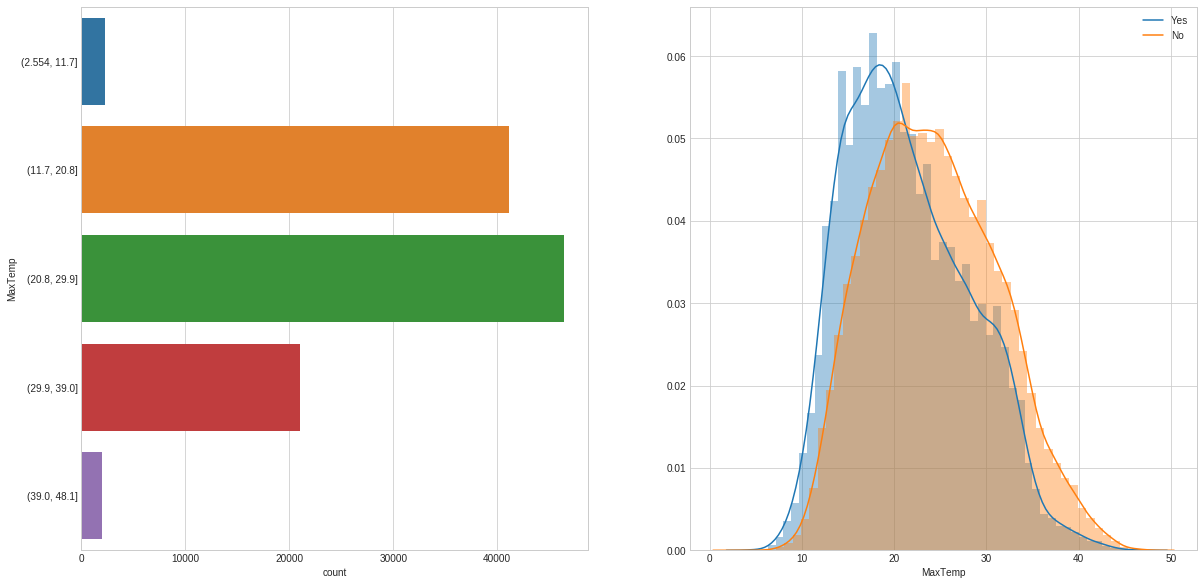

In [123]:
#Calling the function above we will visualise the MaxTemp bin counts as well as the MaxTemp distribution versus RainTomorrow
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'MaxTemp', figsize = (20,10))

The left plot shows how many different values does MinTemp has.The right plot means that when MaxTemp is between 0.0 - 0.4, the target RainTomorrow being 'Yes' is more and when MinTemp is greater than 0.4 the target RainTomorrow being 'No' is more.

**Feature 4 : Rainfall**

Description : The amount of Rainfall in mm recorded for the day

In [124]:
# Let's cross check the missing values
missing_values['Rainfall']

0

In [125]:
data['Rainfall'].value_counts()

0.0      72786
0.2       6566
0.4       2990
0.6       2042
0.8       1622
1.0       1387
1.2       1234
1.4       1130
1.6        955
1.8        870
2.0        813
2.2        779
2.4        684
2.6        663
2.8        581
3.2        557
3.0        548
3.8        492
3.4        475
4.0        455
3.6        447
4.2        420
5.0        365
4.4        358
4.8        345
4.6        342
5.2        324
5.6        288
5.8        286
6.0        284
         ...  
79.8         1
192.0        1
69.5         1
98.2         1
268.6        1
90.0         1
65.4         1
47.8         1
23.9         1
80.8         1
87.0         1
13.9         1
142.8        1
120.2        1
118.0        1
157.8        1
39.9         1
131.4        1
113.8        1
129.0        1
117.6        1
236.8        1
93.4         1
74.2         1
81.2         1
206.2        1
78.6         1
109.6        1
87.4         1
189.0        1
Name: Rainfall, Length: 636, dtype: int64

In [126]:
print("There are {} unique minimum temperature values.".format(len(data.Rainfall.unique())))

There are 636 unique minimum temperature values.


since it is a continuous value, let's do binning and put this to our final_bin datafarme

In [127]:
final_bin['Rainfall'] = pd.cut(data['Rainfall'],bins = 5) #discretising the float numbers into categorical

In [128]:
final_bin['Rainfall'].value_counts()

(-0.368, 73.52]     112634
(73.52, 147.04]        249
(147.04, 220.56]        36
(220.56, 294.08]         5
(294.08, 367.6]          1
Name: Rainfall, dtype: int64

In [129]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


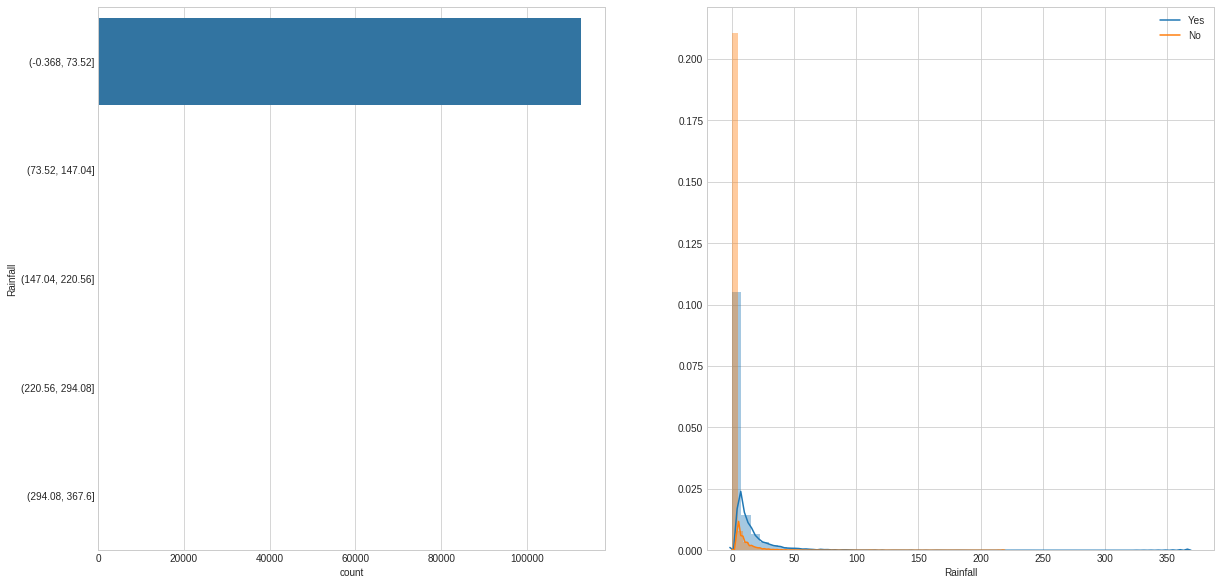

In [130]:
#Calling the function above we will visualise the MaxTemp bin counts as well as the MaxTemp distribution versus RainTomorrow
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'Rainfall', figsize = (20,10))

The left plot shows that most of the values for rainfall in mm lies in between  -0.001 to 0.2 and the right plot shows it is obvious that current day's rainfall of nearly '0'mm indicates that mostly there will be no rainfall next day.

**Feature 5 : WindGustDir**

Description : The direction of the strongest wind gust in the 24 hours to midnight

In [131]:
missing_values['WindGustDir']

0

We have already transformed this categorical variable using dummies, for the system to understand. So let's go ahead and visualise the data

In [132]:
WindGustDir_table = pd.crosstab(index=data["WindGustDir"], columns=data["RainTomorrow"])
WindGustDir_table

RainTomorrow,0,1
WindGustDir,,
E,6676,1159
ENE,5695,1064
ESE,5193,1030
N,5571,2108
NE,4938,1115
NNE,4178,1312
NNW,3725,1509
NW,4570,1834
S,5995,1733


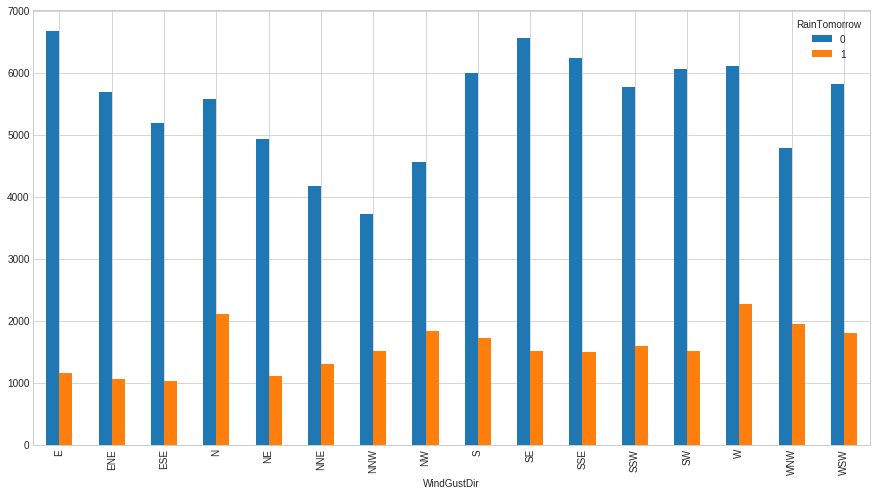

In [133]:
WindGustDir_table.plot(kind="bar", figsize=(15,8),stacked=False)

The insights convey the chances of being RainTomorrow = 'NO' is when wind blows in direction of East,Southeast and South Southeast mostly.and the chances of being RainTomorrow = 'Yes' is when it is North, West and Northwest.

**Feature 5 : WindGustSpeed**

Description : The speed (km/h) of the strongest wind gust in the 24 hours to midnight

In [134]:
missing_values['WindGustSpeed']

0

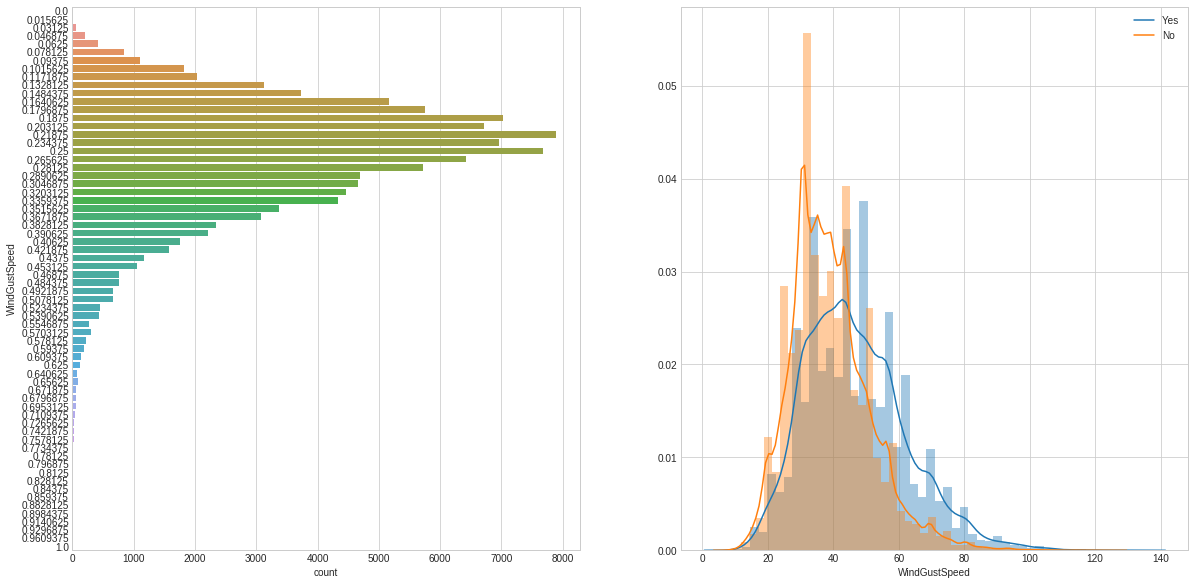

In [135]:
plot_count_dist(df= final, label_column = 'RainTomorrow', target_column = 'WindGustSpeed', figsize = (20,10))

The left plot provides unique values and its numbers of WindGustSpeed whereas right plot explains if there is a WindGustSpeed of 0-50 the currentday, then the next day mostly it will not rain. Otherwisw when WindGustSpeed is greater than 50 it says that the next day can see rain.

**Feature 6 : WindDir9am**

Description : Direction of the wind at 9am

In [136]:
missing_values['WindDir9am']

0

We have already transformed this categorical variable using dummies, for the system to understand. So let's go ahead and visualise the data

In [137]:
WindDir9am_table = pd.crosstab(index=data["WindDir9am"], columns=data["RainTomorrow"])
WindDir9am_table

RainTomorrow,0,1
WindDir9am,,
E,6867,1113
ENE,5675,1183
ESE,5671,954
N,6766,3049
NE,5036,1347
NNE,5044,1905
NNW,4563,1991
NW,4821,1793
S,6080,1436


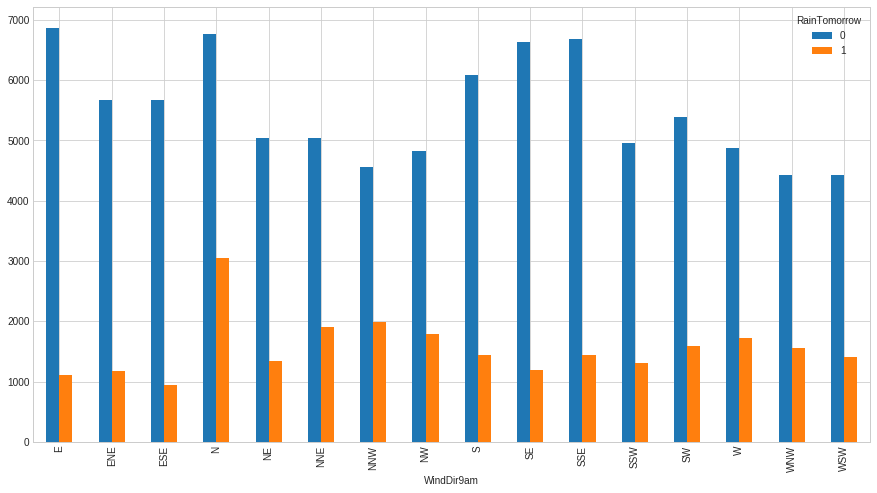

In [138]:
WindDir9am_table.plot(kind="bar", figsize=(15,8),stacked=False)

For RainTomorrow being ‘No’, the wind at morning mostly blows in direction of East,Southeast and South South-east, for RainTomorrow being ‘Yes’, the wind mostly blows in North North-West,North and North North-East.

**Feature 7 : WindDir3pm**

Description : Direction of the wind at 3pm

In [139]:
missing_values['WindDir3pm']

0

We have already transformed this categorical variable using dummies, for the system to understand. So let's go ahead and visualise the data

In [140]:
WindDir3pm_table = pd.crosstab(index=data["WindDir3pm"], columns=data["RainTomorrow"])
WindDir3pm_table

RainTomorrow,0,1
WindDir3pm,,
E,5569,1148
ENE,5376,1150
ESE,5699,1168
N,5157,2044
NE,5354,1268
NNE,3954,1341
NNW,4344,1717
NW,4522,1862
S,6422,1714


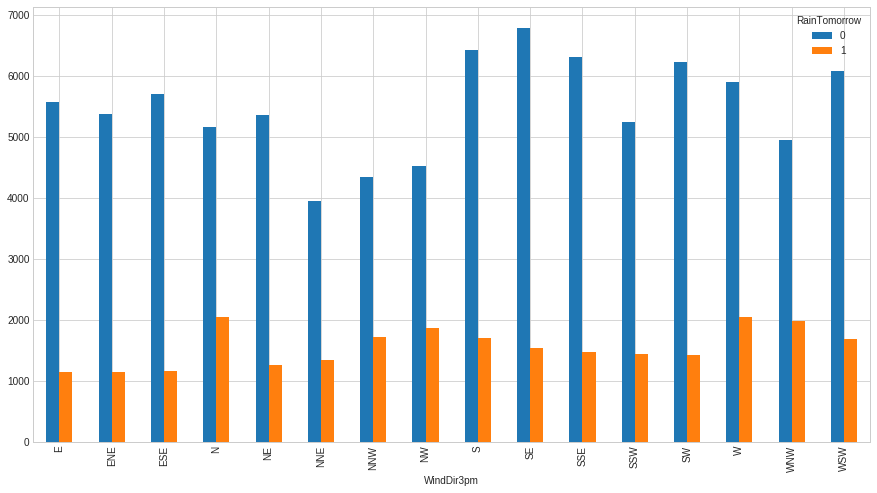

In [141]:
WindDir3pm_table.plot(kind="bar", figsize=(15,8),stacked=False)

For RainTomorrow being ‘Yes’ the wind at evening mostly blows in North, West and West-Northwest and for RainTomorrow being ‘No’, the wind mostly blows in direction of South, SouthEast, West-Southwest.

**Feature 8 : WindSpeed9am**

Description : Wind speed (km/hr) averaged over 10 minutes prior to 9am

In [142]:
missing_values['WindSpeed9am']

0

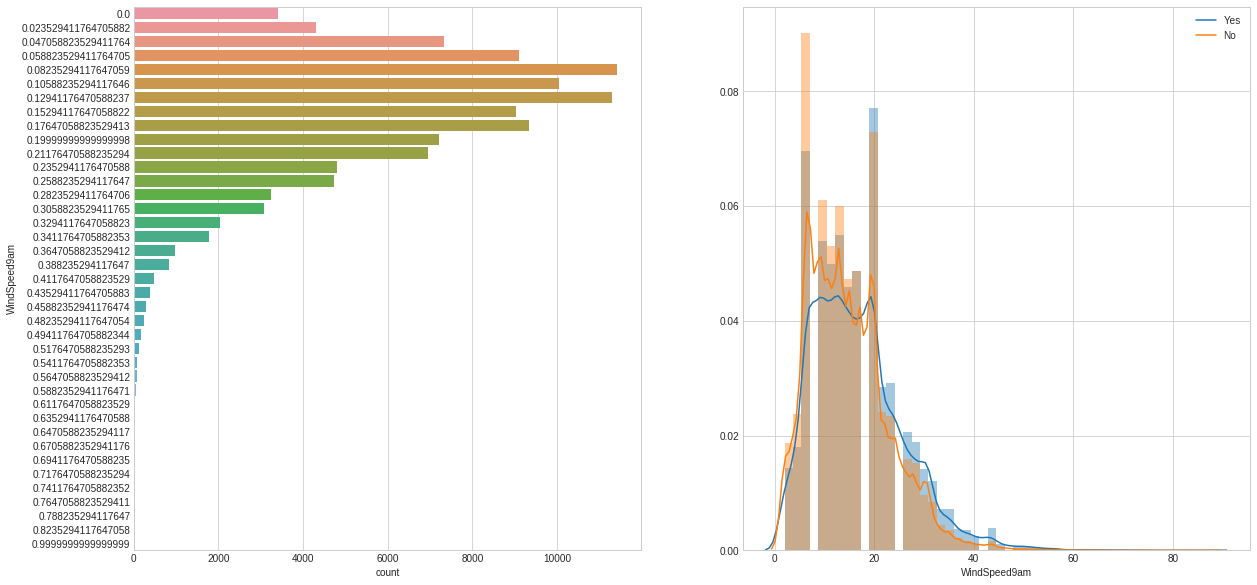

In [143]:
plot_count_dist(df= final, label_column = 'RainTomorrow', target_column = 'WindSpeed9am', figsize = (20,10))

The left plot shows the unique values of WindSpeed9am and their. The frequencyright plot means that for WindSpeed9am of 0-20 km/hr the target RainTomorrow being 'No' is more and having greater than 20 km/hr, the target RainTomorrow being 'Yes' is more.

**Feature 9 : WindSpeed3pm**

Description : Wind speed (km/hr) averaged over 10 minutes prior to 3pm

In [144]:
missing_values['WindSpeed3pm']

0

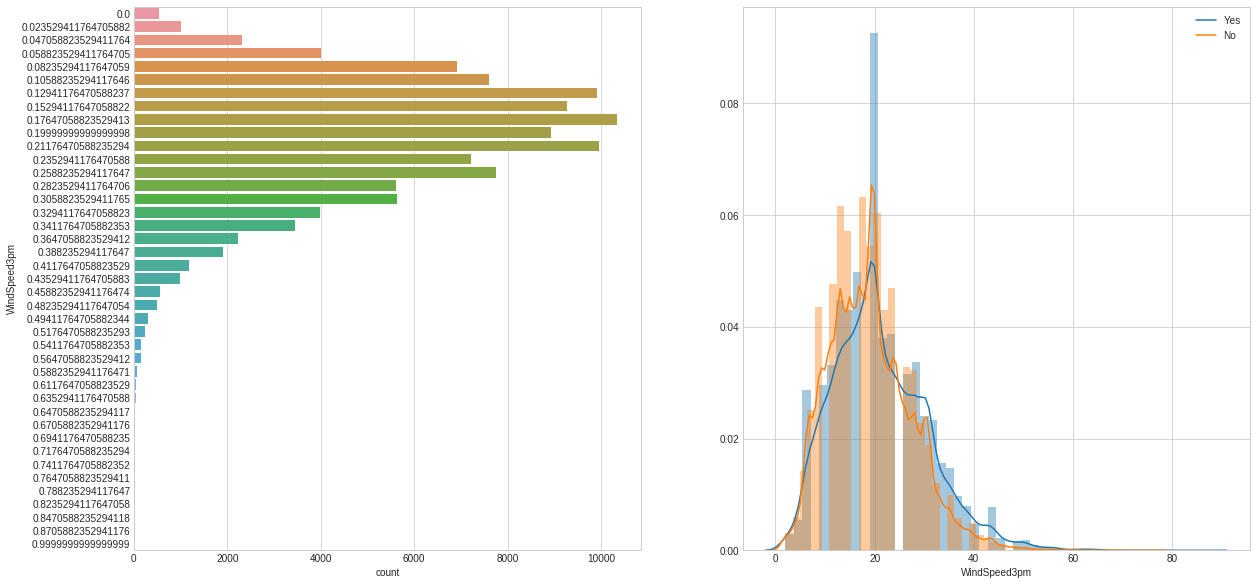

In [145]:
plot_count_dist(df= final, label_column = 'RainTomorrow', target_column = 'WindSpeed3pm', figsize = (20,10))

The left graph shows the frequencies of unique values in WindSpeed3pm and right graph tells that if the WindSpeed3pm reaches 20 km/hr then the target RainTomorrow being 'Yes' is more, greater than 25 km/hr means the target RainTomorrow being ‘No’ has more chance.

**Feature 10 : Humidity9am**

Description : Humidity at 9am in %

In [146]:
missing_values['Humidity9am']

0

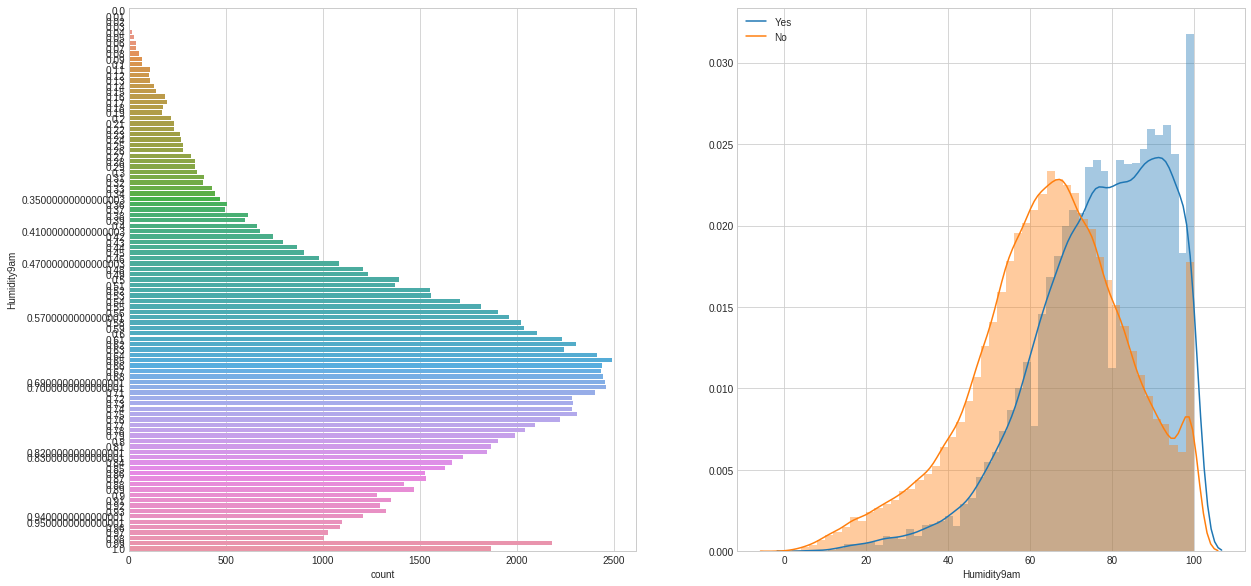

In [147]:
plot_count_dist(df= final, label_column = 'RainTomorrow', target_column = 'Humidity9am', figsize = (20,10))

The left plot shows the frequencies of unique humidity values and right graph means that if Humidity9am is between 0-70 %, then target RainTomorrow will be 'No' and if Humidity9am is more than 70 % the current day then RainTomorrow being 'Yes' is more. And also, we can see that at 100% humidity the case of RainTomorrow = 'Yes' is twice as that of case where RainTomorrow = 'No'.

**Feature 11 : Humidity3pm**

Description : Humidity at 3pm in %

In [148]:
missing_values['Humidity3pm']

0

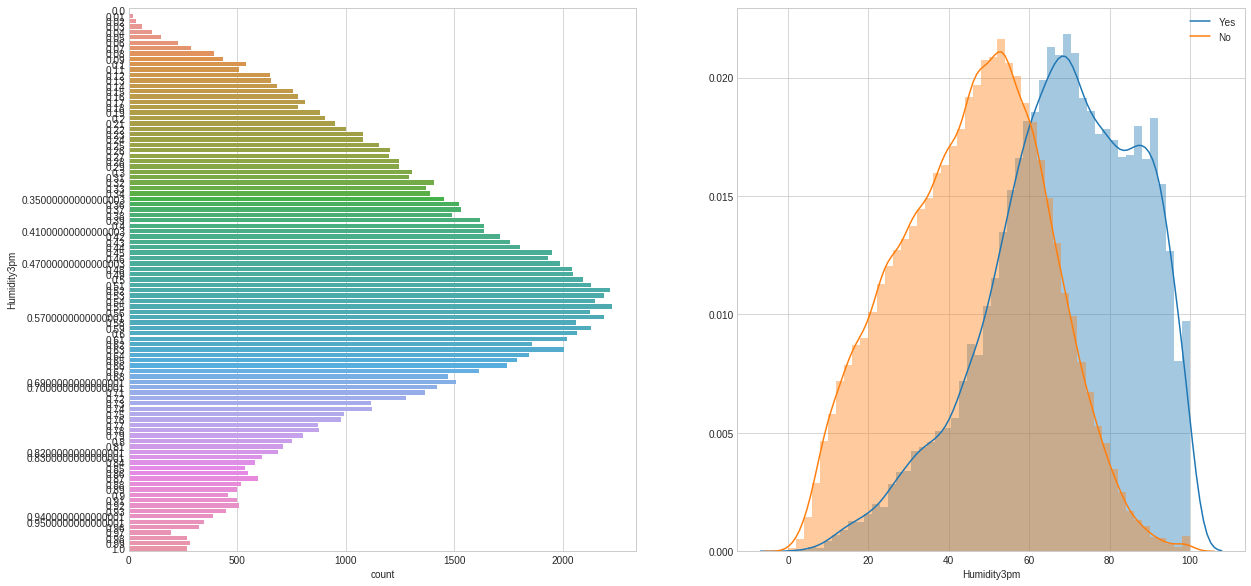

In [149]:
plot_count_dist(df= final, label_column = 'RainTomorrow', target_column = 'Humidity3pm', figsize = (20,10))

The left graph gives the frequencies of unique values for Humidity3pm and right graph clearly draws a line which seperates the Humidity3pm as two ranges where 1. 0-60% - RainTomorrow being 'No' is evident and 2. greater than 60% - RainTomorrow being 'Yes' is evident.

**Feature 12 : Pressure9am**

Description : Atmospheric pressure reduced to mean sea level at 9am, measured in hpa

In [150]:
missing_values['Pressure9am']

0

In [151]:
final['Pressure9am'].value_counts()

0.593388    726
0.585124    693
0.618182    693
0.601653    678
0.619835    676
0.631405    674
0.608264    673
0.616529    673
0.578512    667
0.613223    667
0.591736    666
0.614876    666
0.581818    665
0.598347    660
0.623140    658
0.611570    658
0.595041    655
0.606612    654
0.629752    651
0.621488    651
0.646281    651
0.573554    647
0.639669    646
0.590083    645
0.583471    645
0.642975    642
0.563636    641
0.555372    639
0.586777    639
0.575207    638
           ... 
0.155372      1
0.095868      1
0.978512      1
0.965289      1
0.094215      1
0.140496      1
0.109091      1
0.983471      1
0.975207      1
0.105785      1
0.127273      1
0.089256      1
0.100826      1
0.991736      1
0.102479      1
0.122314      1
0.163636      1
0.064463      1
0.024793      1
0.087603      1
0.166942      1
0.180165      1
1.000000      1
0.029752      1
0.143802      1
0.074380      1
0.107438      1
0.052893      1
0.056198      1
0.000000      1
Name: Pressure9am, Lengt

since it is a floating value, let's do binning and put this to our final_bin dataframe

In [152]:
final_bin['Pressure9am'] = pd.cut(data['Pressure9am'],bins = 5) #discretising the float numbers into categorical

In [153]:
final_bin['Pressure9am'].value_counts()

(1016.8, 1028.9]    54305
(1004.7, 1016.8]    48895
(1028.9, 1041.0]     5806
(992.6, 1004.7]      3772
(980.44, 992.6]       147
Name: Pressure9am, dtype: int64

In [154]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


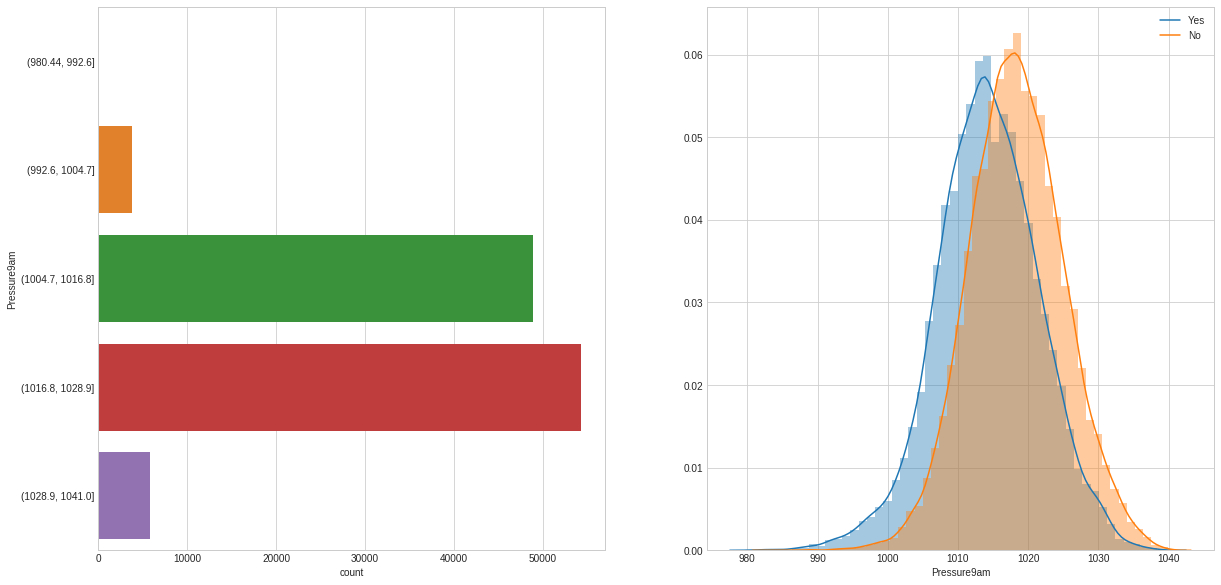

In [155]:
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'Pressure9am', figsize = (20,10))

The graph on the left provides histogram with bins for Pressure9am and the plot on left illustrates that pressure of 0-1015 hpa has more chances of RainTomorrow being 'Yes' and pressure greater the above range means target RainTomorrow being 'No'.

**Feature 13 : Pressure3pm**

Description : Atmospheric pressure reduced to mean sea level at 3pm, measured in hpm

In [156]:
missing_values['Pressure3pm']

0

In [157]:
final['Pressure3pm'].value_counts()

0.6144    691
0.6080    681
0.6112    680
0.5824    680
0.6160    679
0.6176    678
0.6128    663
0.6032    663
0.6048    658
0.6192    657
0.6304    654
0.5616    653
0.6096    651
0.6224    648
0.5776    648
0.5984    645
0.5808    645
0.5872    644
0.5856    643
0.5968    640
0.5840    637
0.6272    633
0.5888    632
0.6208    632
0.5936    630
0.6448    629
0.6352    629
0.6064    629
0.6400    627
0.5792    625
         ... 
0.1808      1
0.1264      1
0.0816      1
0.1312      1
0.1760      1
0.0992      1
0.9680      1
0.9616      1
0.1104      1
0.0688      1
0.1776      1
0.0176      1
0.1360      1
0.0928      1
0.1552      1
0.1280      1
0.1824      1
0.1328      1
0.9728      1
0.9664      1
0.1840      1
0.1184      1
0.0656      1
0.1424      1
0.1168      1
0.9520      1
0.1296      1
0.0768      1
0.0880      1
0.0000      1
Name: Pressure3pm, Length: 541, dtype: int64

since it is a floating value, let's do binning and put this to our final_bin dataframe

In [158]:
final_bin['Pressure3pm'] = pd.cut(data['Pressure3pm'],bins = 5) #discretising the float numbers into categorical


In [159]:
final_bin['Pressure3pm'].value_counts()

(1014.6, 1027.1]    54808
(1002.1, 1014.6]    50147
(1027.1, 1039.6]     4729
(989.6, 1002.1]      3147
(977.038, 989.6]       94
Name: Pressure3pm, dtype: int64

In [160]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


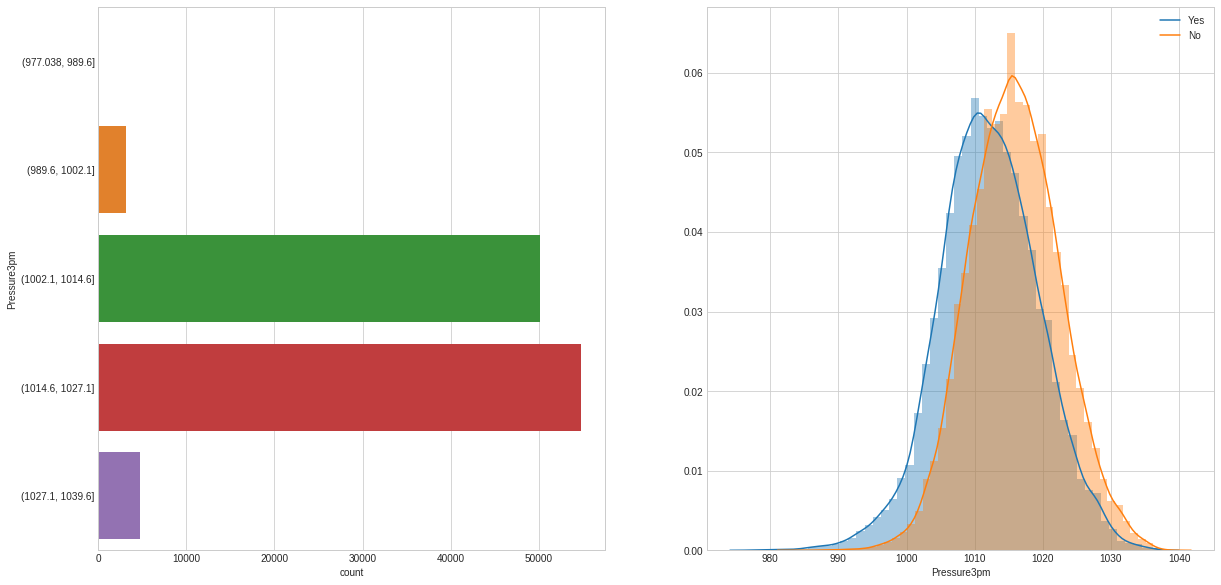

In [161]:
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'Pressure3pm', figsize = (20,10))

The graph on the left provides binned histogram for Humidity9am and the plot on left illustrates that pressure of 0-1012 hpa has more chances of RainTomorrow being 'Yes' and pressure greater the above range means target RainTomorrow being 'No'.

**Feature 14 : Temp9am**

Description : Temperature at 9am, measured in degrees Celsius

In [162]:
missing_values['Temp9am']

0

In [163]:
final['Temp9am'].value_counts()

0.413395    704
0.454965    704
0.390300    697
0.431871    692
0.457275    689
0.411085    688
0.420323    686
0.427252    681
0.464203    679
0.441109    677
0.438799    675
0.468822    670
0.443418    667
0.471132    663
0.459584    660
0.397229    656
0.494226    655
0.404157    654
0.408776    653
0.478060    652
0.415704    652
0.381062    651
0.461894    650
0.482679    649
0.466513    648
0.452656    648
0.418014    643
0.394919    643
0.422633    642
0.392610    641
           ... 
0.055427      3
0.921478      3
0.930716      3
0.942263      3
0.066975      3
0.914550      3
0.939954      3
0.923788      2
0.046189      2
0.069284      2
0.879908      2
0.935335      2
0.062356      2
0.907621      2
0.916859      1
0.053118      1
0.956120      1
0.946882      1
0.972286      1
1.000000      1
0.981524      1
0.974596      1
0.039261      1
0.963048      1
0.949192      1
0.937644      1
0.969977      1
0.064665      1
0.926097      1
0.000000      1
Name: Temp9am, Length: 3

since it is a continuous value, let's do binning and put this to our final_bin dataframe

In [164]:
final_bin['Temp9am'] = pd.cut(data['Temp9am'],bins = 5) #discretising the float numbers into categorical

In [165]:
final_bin['Temp9am'].value_counts()

(14.22, 22.88]    50671
(5.56, 14.22]     35946
(22.88, 31.54]    23289
(-3.143, 5.56]     2022
(31.54, 40.2]       997
Name: Temp9am, dtype: int64

In [166]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


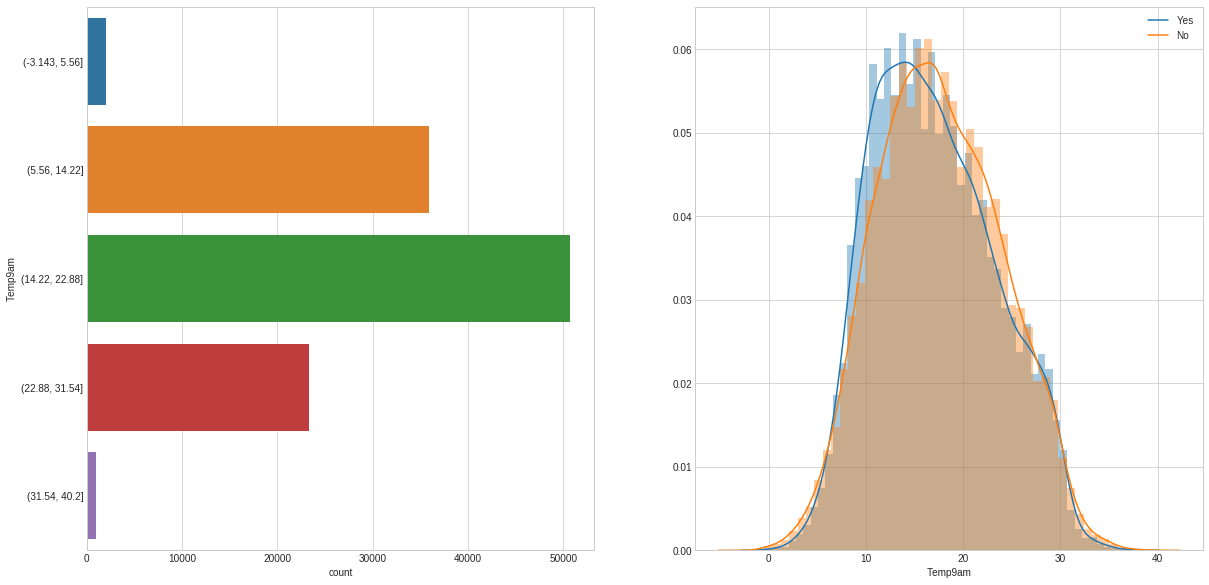

In [167]:
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'Temp9am', figsize = (20,10))

The graph on the left shows the binned histogram for Temp9am and we can see the most frequent temperature being in [14.22,22.88]. The right graph conveys that temperature between 7 and 15 degree Celsius mostly results in RainTomorrow being 'Yes', otherwise results in RainTomorrow being ‘No’.

**Feature 15 : Temp3pm**

Description : Temperature at 3pm, measured in degree Celsius

In [168]:
missing_values['Temp3pm']

0

In [169]:
final['Temp3pm'].value_counts()

0.391111    680
0.371111    679
0.393333    654
0.406667    649
0.377778    648
0.375556    645
0.386667    635
0.384444    633
0.357778    633
0.373333    631
0.400000    629
0.473333    627
0.342222    625
0.382222    625
0.408889    622
0.435556    621
0.388889    619
0.362222    619
0.464444    617
0.404444    614
0.397778    612
0.426667    610
0.420000    609
0.442222    609
0.368889    608
0.422222    607
0.448889    607
0.497778    605
0.346667    604
0.428889    603
           ... 
0.940000      4
0.986667      3
0.931111      3
0.082222      3
0.928889      3
0.966667      2
0.980000      2
0.075556      2
0.064444      2
0.942222      2
0.955556      2
0.057778      2
0.077778      2
0.066667      2
0.037778      2
0.951111      2
0.933333      2
0.971111      1
0.960000      1
0.000000      1
0.962222      1
0.033333      1
0.048889      1
1.000000      1
0.044444      1
0.968889      1
0.013333      1
0.982222      1
0.946667      1
0.948889      1
Name: Temp3pm, Length: 4

since it is a continuous value, let's do binning and put this to our final_bin dataframe

In [170]:
final_bin['Temp3pm'] = pd.cut(data['Temp3pm'],bins = 5) #discretising the float numbers into categorical


In [171]:
final_bin['Temp3pm'].value_counts()

(19.7, 28.7]     46788
(10.7, 19.7]     42455
(28.7, 37.7]     18989
(1.655, 10.7]     2985
(37.7, 46.7]      1708
Name: Temp3pm, dtype: int64

In [172]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


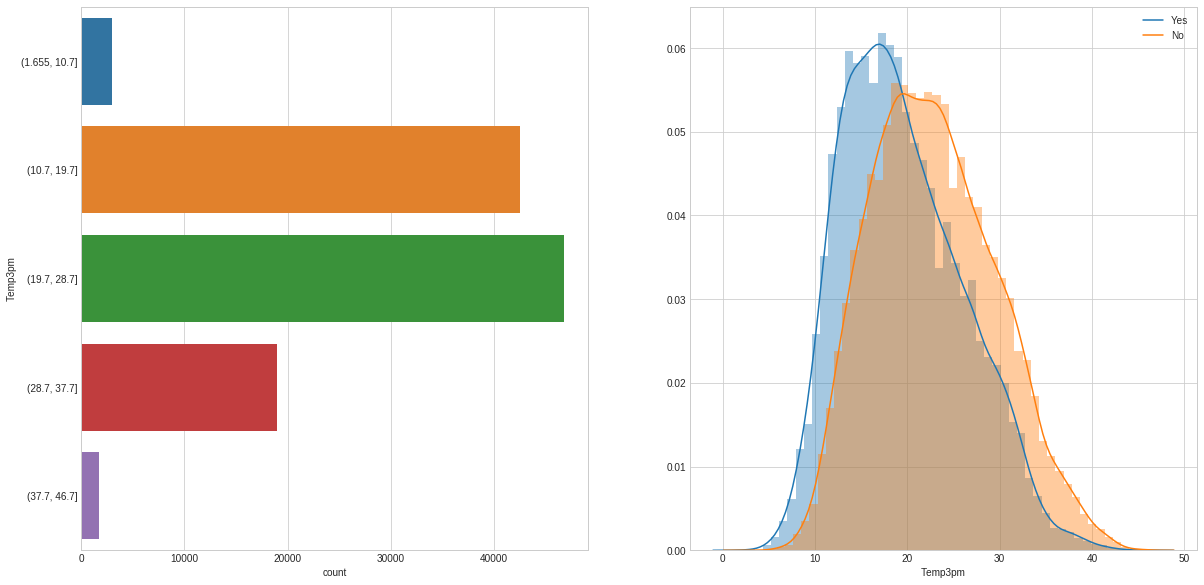

In [173]:
plot_count_dist(df= final_bin, label_column = 'RainTomorrow', target_column = 'Temp3pm', figsize = (20,10))

The graph on the left shows the binned histogram for Temp9am and we can see the most frequent temperature being in [19.7,28.7]. The right graph conveys that temperature between 0 and 19 degree Celsius mostly results in RainTomorrow being 'Yes'. Temperature grater than 20 degree celsius results in mostly target RainTomorrow being 'No'.

**Feature 16 : RainToday**

Description : Precipitation of current day. Boolean: 1 if precipitation (in mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

0.0    87556
1.0    25369
Name: RainToday, dtype: int64


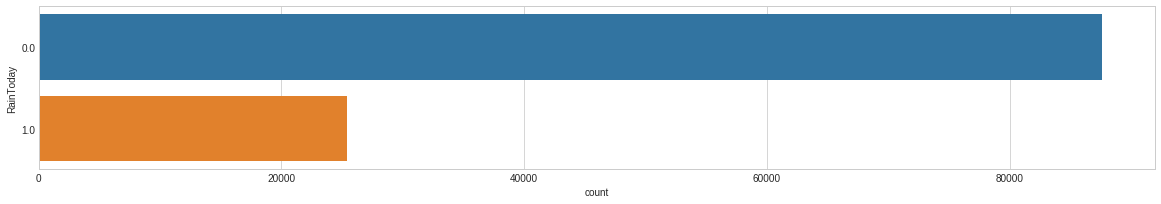

In [174]:
#Now we will just see how many times it rained the current day?
fig = plt.figure(figsize = (20,3))
sns.countplot(y='RainToday', data=final);
print(final.RainToday.value_counts())

From the graph we can know the ratio of cases where the next day is predicted as rainy day or not. The table above the graph presents frequency counts for the binary values 'Yes' and 'No' for RainToday.

In [175]:
final.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.513064,0.446154,0.001632,0.289062,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.370546,0.494505,0.000000,0.289062,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.501188,0.507692,0.000000,0.304688,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.413302,0.558242,0.000000,0.132812,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.610451,0.652747,0.002720,0.265625,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**CORRELATION MATRIX**

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text xticklabel objects>)

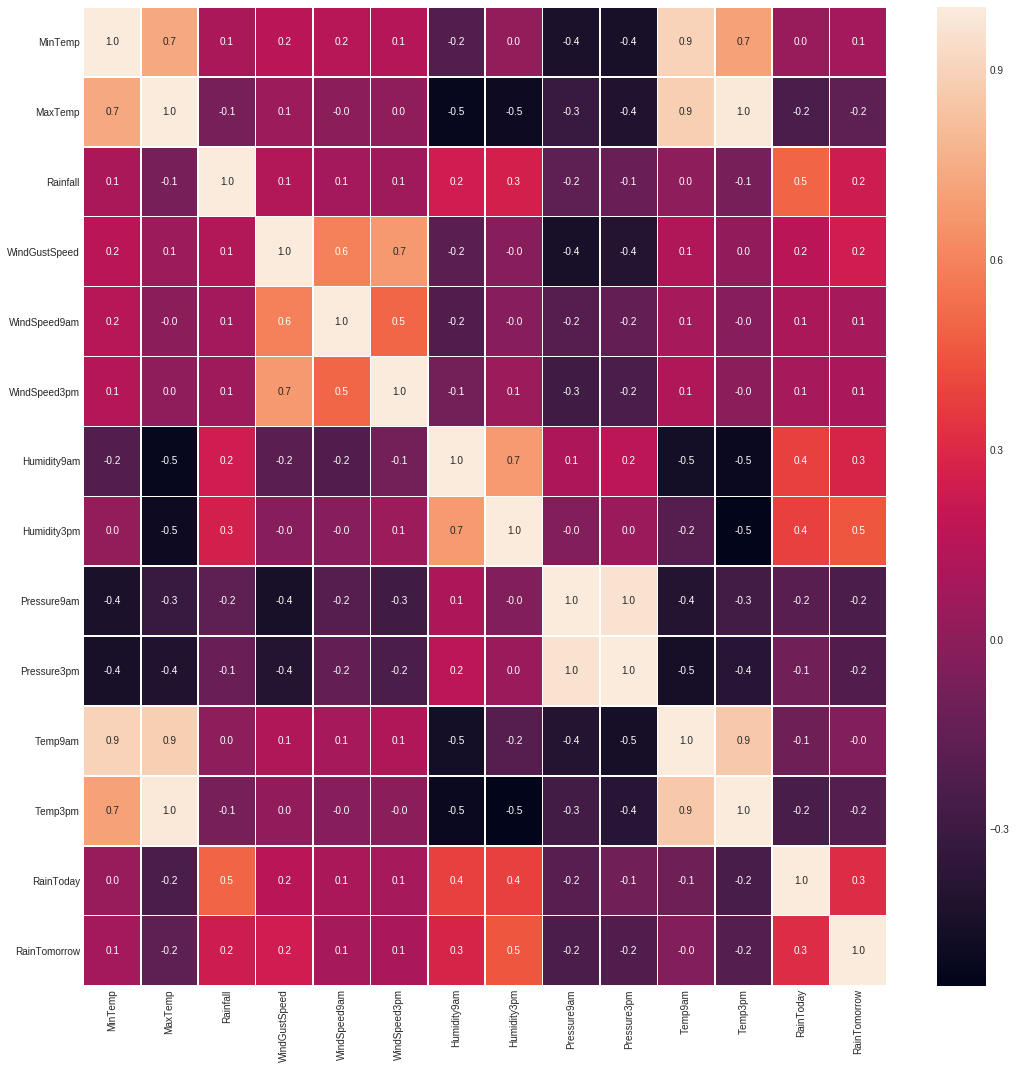

In [191]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.xticks(rotation=90)

Below are the insights drawn from correlation matrix:
*	MinTemp and MaxTemp are highly correlated with r=0.7  
*	Humidity3pm and Humidity 9am are highly correlated with r=0.6  
*	Temp9am and MinTemp are highly correlated with r=0.9  
*	Temp9am and MaxTemp are highly correlated with r=0.9  
*	Temp3pm and MinTemp are highly correlated with r=0.6  
*	Temp3pm and MaxTemp are highly correlated with r=0.9  
*	Also, Pressure & temperature and Humidity and temperature were negatively correlated.  

Now we are done with pre-processing and have a basic ides of what each features are and how they are related to the target variable RainTomorrow.
Let's just see which are the important features to predict RainTomorrow

In [176]:
final_bin.head()

,RainTomorrow,MinTemp,MaxTemp,Rainfall,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,0.0,"(8.64, 17.06]","(20.8, 29.9]","(-0.368, 73.52]","(1004.7, 1016.8]","(1002.1, 1014.6]","(14.22, 22.88]","(19.7, 28.7]"
1,0.0,"(0.22, 8.64]","(20.8, 29.9]","(-0.368, 73.52]","(1004.7, 1016.8]","(1002.1, 1014.6]","(14.22, 22.88]","(19.7, 28.7]"
2,0.0,"(8.64, 17.06]","(20.8, 29.9]","(-0.368, 73.52]","(1004.7, 1016.8]","(1002.1, 1014.6]","(14.22, 22.88]","(19.7, 28.7]"
3,0.0,"(8.64, 17.06]","(20.8, 29.9]","(-0.368, 73.52]","(1016.8, 1028.9]","(1002.1, 1014.6]","(14.22, 22.88]","(19.7, 28.7]"
4,0.0,"(17.06, 25.48]","(29.9, 39.0]","(-0.368, 73.52]","(1004.7, 1016.8]","(1002.1, 1014.6]","(14.22, 22.88]","(28.7, 37.7]"


In [177]:
final.shape

(112925, 62)

In [178]:
#Let's get hold of the independent variables and assign them as X

X = final.loc[:, final.columns != 'RainTomorrow']
y = final['RainTomorrow']
X.shape

(112925, 61)

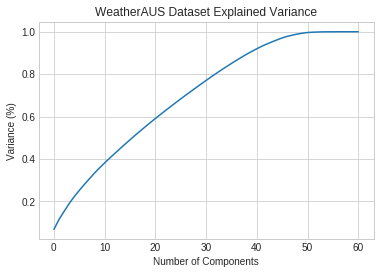

In [179]:
# PCA to find the best number of features based on explained variance for each attribute
#Fitting the PCA algorithm with our Data
from sklearn.decomposition import PCA
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('WeatherAUS Dataset Explained Variance')
plt.show()

In [180]:
#Using SelectKBest to get the top features!
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=40)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)]) #top 40 columns

Index(['MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp3pm',
       'RainToday', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE',
       'WindGustDir_N', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE',
       'WindDir3pm_N', 'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_SE',
       'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir9am_E',
       'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_SE', 'WindDir9am_SSE',
       'WindDir9am_W', 'WindDir9am_WNW'],
      dtype='object')


In [181]:
X = final[['MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp3pm',
       'RainToday', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE',
       'WindGustDir_N', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE',
       'WindDir3pm_N', 'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_SE',
       'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir9am_E',
       'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_SE', 'WindDir9am_SSE',
       'WindDir9am_W', 'WindDir9am_WNW']] # let's use all 40 features
y = final[['RainTomorrow']]

In [182]:
#Split the data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

Let us start building our predictive models

**Model 1 : Logistic Regression**

In [183]:
from sklearn.metrics import accuracy_score
import time
t0=time.time()
logreg = LogisticRegression(random_state=0, class_weight={0:0.3,1:0.7})
logreg = logreg.fit(X_train,y_train)
y_predLR = logreg.predict(X_test)
score = accuracy_score(y_test,y_predLR)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)





Accuracy : 0.8283862283933126
Time taken : 1.1252613067626953


**Model 2 : Decision Tree**

In [184]:
t0=time.time()
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
dt = DecisionTreeClassifier(random_state=0,class_weight={0:0.3,1:0.7})
dt.fit(X_train,y_train)
y_predDT = dt.predict(X_test)
score = accuracy_score(y_test,y_predDT)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

Accuracy : 0.7866605270614905
Time taken : 1.6404452323913574


**Model 3 : RandomForest**

In [185]:
from sklearn.ensemble import RandomForestClassifier
t0=time.time()
rf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0,class_weight={0:0.3,1:0.7})
rf.fit(X_train,y_train)
y_predRF = rf.predict(X_test)
score = accuracy_score(y_test,y_predRF)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

Accuracy : 0.8252691980731085
Time taken : 5.8068389892578125


**Model 4 : BalancedBagging Classifier**

In [186]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Creating an object of the classifier.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

#Training the classifier.
bbc.fit(X_train, y_train)
y_predBBC = bbc.predict(X_test)
score = accuracy_score(y_test,y_predBBC)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

Accuracy : 0.818326721450836
Time taken : 12.939156770706177


> **CONFUSION MATRICES**

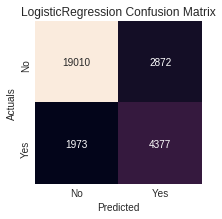

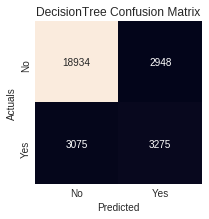

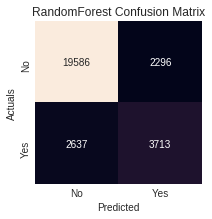

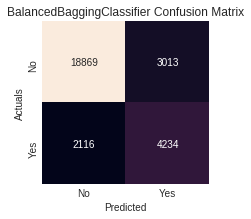

In [187]:
from sklearn.metrics import confusion_matrix
pred_models = []
pred_models.append(('LogisticRegression', y_predLR))
pred_models.append(('DecisionTree', y_predDT))
pred_models.append(('RandomForest', y_predRF))
pred_models.append(('BalancedBaggingClassifier', y_predBBC))


for name, pred_model in pred_models:
    cm = confusion_matrix(y_test, pred_model)
    #print(cm)
    plt.figure(figsize = (3,3))
    sns.heatmap(cm,fmt="d",annot=True,xticklabels=["No","Yes"],yticklabels=["No","Yes"],cbar=False)
    plt.title(name+" "+"Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actuals")
    plt.show()